# Recommendation system based on PySpark

In this tutorial I am going to demonstrate how Spark MLlib can be used for movie recommendation task.

First, let me start from problem statement: goal of any recommendation system is to analyze how users interact with existing system and make some recommendation of what they can buy, listen or watch in the future so that we can make our users happier, and hopefully, increase profitability of system we develop.

There are several approaches to this task due to [wiki](https://en.wikipedia.org/wiki/Recommender_system): 
* Collaborative filtering 
methods are based on collecting and analyzing a large amount of information on users’ behaviors, activities or preferences and predicting what users will like based on their similarity to other users. A key advantage of the collaborative filtering approach is that it does not rely on machine analyzable content and therefore it is capable of accurately recommending complex items such as movies without requiring an "understanding" of the item itself. Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past.
* Content-based filtering
methods are based on a description of the item and a profile of the user’s preferences.
In a content-based recommender system, keywords are used to describe the items and a user profile is built to indicate the type of item this user likes. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.
* Hybrid recommender systems
which is combining collaborative filtering and content-based filtering could be more effective in some cases. Hybrid approaches can be implemented in several ways: by making content-based and collaborative-based predictions separately and then combining them; by adding content-based capabilities to a collaborative-based approach (and vice versa); or by unifying the approaches into one mode. 

In this work I will demonstrate how to use Collaborative Filtering approach using Spark MLlib. 

# Dataset

In my case I would like to recommend movies to users, based on dataset provided by [Megogo](https://megogo.net/ru) and competition they hosted at [Kaggle](https://www.kaggle.com/c/megogochallenge). 

I've been participated in this competiton during mlcourse and took 10th place out of 42 teams there. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

%env JOBLIB_TEMP_FOLDER=/tmp 
#https://www.kaggle.com/getting-started/45288 - this helps some with 'no space left on device'

#print(os.listdir("../input/megogochallenge/"))

env: JOBLIB_TEMP_FOLDER=/tmp


Displaying data so that you could undesrtand how it looks like: 

In [2]:
full_df = pd.read_csv('../input/megogochallenge/train_data_full.csv')
full_df.head()

,session_start_datetime,user_id,user_ip,primary_video_id,video_id,vod_type,session_duration,device_type,device_os,player_position_min,player_position_max,time_cumsum_max,video_duration,watching_percentage
0,2018-07-01 00:00:02.135,21603820,27241033,9583642,9583642,svod,688,web,Windows_10,6940,6940,93,8198,0.0839
1,2018-07-01 00:00:02.232,35636970,10887511,24645936,24645936,advod,3174,mobile,android,599,3173,0,5297,0.5990
2,2018-07-01 00:00:06.961,78312976,15427448,25397362,23346676,advod,3054,tv,samsung,599,3052,3032,3052,1.0000
3,2018-07-01 00:00:11.044,122261599,12021384,5205267,22898606,svod,2400,tv,netcast,600,2400,2378,2638,0.9100
4,2018-07-01 00:00:14.054,53477088,65858458,14098190,14098190,advod,2481,tv,webos,137,4849,2316,5115,0.4850


It's very important not only to recommend movies that user would like to watch. But to recommend movies which user will watch more than on half. It could be observed in `watching_percentage` column. 

Actually it was a goal of competition (to predict movies that will be watched more than on half). 

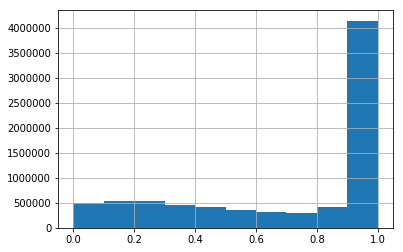

In [3]:
full_df['watching_percentage'].hist()

We see that most movies are watched till the end.

## Metric

As evaluation metric MAP@10 is used for competiton - it's variations is very common metric for any recommendation tasks. More about it you could read [here](http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html).

But in this tutorial I'll use RMSE, which is easier to understand for everyone.

# PySpark implementation

Finally, let's move to PySpark. 
There is 2 ways to install it in Kaggle Kernels: 
* Run magic command, as in cell below
* Or go to Packages and enter pyspark (it will take some time, but this will form your own version of docker and you'll no need to waste time while running next versions of kernel)

In [4]:
!pip install pyspark

To install it locally or at jupyter server follow [this](https://medium.freecodecamp.org/how-to-set-up-pyspark-for-your-jupyter-notebook-7399dd3cb389) instruction. 

First, you have to install Java and Scala. Then set enviroment variables to launch Spark with Python3 and finally install pyspark.

Now importing all needed spark modules. Pay attention how sc and spark variables were initialized. 

In [5]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator

sc = SparkContext('local') #https://stackoverflow.com/questions/30763951/spark-context-sc-not-defined
spark = SparkSession(sc)

Let's read data in Spark format: 

In [6]:
data_schema = StructType([
    StructField('session_start_datetime',TimestampType(), False),
    StructField('user_id',IntegerType(), False),
    StructField('user_ip',IntegerType(), False),
    StructField('primary_video_id',IntegerType(), False),
    StructField('video_id',IntegerType(), False),
    StructField('vod_type',StringType(), False),
    StructField('session_duration',IntegerType(), False),
    StructField('device_type',StringType(), False),
    StructField('device_os',StringType(), False),
    StructField('player_position_min',LongType(), False),
    StructField('player_position_max',LongType(), False),
    StructField('time_cumsum_max',LongType(), False),
    StructField('video_duration',IntegerType(), False),
    StructField('watching_percentage',FloatType(), False)
])
final_stat = spark.read.csv(
    '../input/megogochallenge/train_data_full.csv', header=True, schema=data_schema
).cache()

Let's prepare data for model: 

In [7]:
ratings = (final_stat
    .select(
        'user_id',
        'primary_video_id',
        'watching_percentage',
    )
).cache()

Making a `train_test_split`: 

In [8]:
(training, test) = ratings.randomSplit([0.8, 0.2])

[](http://)Finally build an [ALS](https://dl.acm.org/citation.cfm?id=1608614) model:

In [9]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=2, regParam=0.01, 
          userCol="user_id", itemCol="primary_video_id", ratingCol="watching_percentage",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="watching_percentage",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.7092173090577979


Let's take a look on parameters, and try to find any improvements. 

Parameters of ALS Model in PySpark realization are following: 
* **NumBlocks** is the number of blocks the users and items will be partitioned into in order to parallelize computation.
* **rank** is the number of latent factors in the model.
* **maxIter** is the maximum number of iterations to run.
* **regParam** specifies the regularization parameter in ALS.
* **implicitPrefs** specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
* **alpha** is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).

## Explicit or implicit? 

The standard approach to matrix factorization based collaborative filtering treats the entries in the user-item matrix as explicit preferences given by the user to the item, for example, users giving ratings to movies.

As we see in our dataset we have a bunch of implicit information like `device_type`, `video_duration`, `device_os`. 
But let's try to use only explicit information and look on RMSE.

In [10]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=2, regParam=0.01, 
          userCol="user_id", itemCol="primary_video_id", ratingCol="watching_percentage",
          coldStartStrategy="drop",
          implicitPrefs=False) #changed param!
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="watching_percentage",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.42465506263708164


Wow! Our RMSE improved really well!
But remember, if the rating matrix is derived from another source of information (i.e. it is inferred from other signals), you can set `implicitPrefs` to `True` to get better results. 

Could we do more? 
Let me increase `rank`, which is number of latent factor a bit. 

In [11]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank=20, #10 was by default
          maxIter=2, regParam=0.01,
          userCol="user_id", itemCol="primary_video_id", ratingCol="watching_percentage",
          coldStartStrategy="drop",
          implicitPrefs=False)
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="watching_percentage",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))


Root-mean-square error = 0.400582274318481


Great! Our score is improved a bit, but not dramatically. 

Here I should say that I am a bit limited by Kaggle Kernels resources (Spark use a lot of RAM!) and of course it's better to experiment with parameters locally.

General recommendations: 
* increase `maxIter` and `rank` checking them on CV of course (may be time and RAM consuming). 
* don't forget about regularization parametr

Okay, now I want to output the recommendations itself.

In [12]:
%%time
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.count()
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
movieRecs.count()

CPU times: user 188 ms, sys: 100 ms, total: 288 ms
Wall time: 8min 44s


Converting Spark data to well-known Pandas could be done easily with `toPandas()` method: 

In [13]:
userRecs_df = userRecs.toPandas()
print(userRecs_df.shape)

movieRecs_df = movieRecs.toPandas()
print(movieRecs_df.shape)

(401553, 2)
(7220, 2)


In [14]:
userRecs_df.head()

,user_id,recommendations
0,7340,"[(27987803, 2.907897472381592), (28900883, 2.5..."
1,28577,"[(15729968, 2.7276458740234375), (18544535, 2...."
2,38723,"[(19875588, 2.8586254119873047), (24694479, 2...."
3,119432,"[(13028255, 2.3740458488464355), (13071722, 2...."
4,188122,"[(32614008, 3.399120807647705), (10108953, 3.2..."


Here we see movie recommendation and it's score by each user.

In [15]:
movieRecs_df.head()

,primary_video_id,recommendations
0,2503270,"[(50245367, 1.7377479076385498), (69026283, 1...."
1,16598040,"[(30700999, 3.5905983448028564), (90627429, 3...."
2,26049640,"[(46116994, 1.8512648344039917), (47528753, 1...."
3,2801091,"[(103819960, 2.200399398803711), (26814334, 2...."
4,20929121,"[(33491259, 2.3538997173309326), (22162048, 2...."


Here we see recommendation and it's score by each movie.

# Summary

In summary, collaborative filtering is one of the most popular approach to build recommendation system. 
Movie recommendation task become extremely popular after [Netflix competition](https://en.wikipedia.org/wiki/Netflix_Prize) with one million dollar prize, which push Machine Learning a lot in recommender systems field. 

With PySpark, we could get great results in this task just in a few lines of code. 
In production, new problems appeared, on of them is **cold start** problem when we have no any historical information about user, but still have to recommend something.
But that's more than this tutorial would like to cover.

Hope this small intro was useful, feel free to criticize, discuss, and maybe upvote:) 

## References

* [Spark docs](https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html)
* [Megogo challenge baselines](https://github.com/SantyagoSeaman/megogo_challenge_solutions)
* [More on ranking metrics](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.evaluation.RankingMetrics)
* [How does netflix recommeder system works](https://help.netflix.com/en/node/100639)



